## Fontes das funções

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def grafico_correlacoes(csv_path, coluna_alvo):
    # Lê o CSV
    df = pd.read_csv(csv_path)
    
    # Garante que só colunas numéricas sejam usadas na correlação
    df_numerico = df.select_dtypes(include='number')
    
    if coluna_alvo not in df_numerico.columns:
        raise ValueError(f"A coluna '{coluna_alvo}' não é numérica ou não está no dataset.")

    # Calcula a correlação da coluna alvo com todas as outras
    correlacoes = df_numerico.corr()[coluna_alvo].drop(labels=[coluna_alvo])

    # Ordena por valor da correlação
    correlacoes_ordenadas = correlacoes.sort_values(ascending=False)

    # Plotando o gráfico
    plt.figure(figsize=(10, 6))
    sns.barplot(x=correlacoes_ordenadas.values, y=correlacoes_ordenadas.index, palette='coolwarm', orient='h')
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.title(f'Correlação com a coluna "{coluna_alvo}"')
    plt.xlabel('Coeficiente de Correlação de Pearson')
    plt.ylabel('Colunas')
    plt.tight_layout()
    plt.show()

def substituir_nulos_por_mediana(caminho_entrada, caminho_saida, coluna):
    # Lê os dados
    df = pd.read_csv(caminho_entrada)

    # Conta o número de valores nulos antes da substituição
    nulos_originais = df[coluna].isnull().sum()

    # Substitui nulos pela mediana
    coluna_median = df[coluna].median()
    df[coluna].fillna(coluna_median, inplace=True)

    # Conta o número de valores modificados
    nulos_modificados = nulos_originais - df[coluna].isnull().sum()

    # Calcula a média dos valores substituídos
    media_substituida = df[coluna].loc[df[coluna] == coluna_median].mean()

    # Salva os dados atualizados em outro arquivo
    df.to_csv(caminho_saida, index=False)

    # Exibe os resultados
    print(f'Número de valores nulos em "{coluna}" antes: {nulos_originais}')
    print(f'Número de valores modificados em "{coluna}": {nulos_modificados}')
    print(f'Média dos valores substituídos em "{coluna}": {media_substituida}')

def substituir_nulos_por_correlacao(caminho_entrada, caminho_saida, coluna_alvo, coluna_referencia, limite_correlacao=0.7):
    df = pd.read_csv(caminho_entrada)

    # Validação das colunas
    if coluna_alvo not in df.columns or coluna_referencia not in df.columns:
        raise ValueError(f"Colunas '{coluna_alvo}' e/ou '{coluna_referencia}' não existem no arquivo.")

    # Força conversão para numérico
    df[coluna_alvo] = pd.to_numeric(df[coluna_alvo], errors='coerce')
    df[coluna_referencia] = pd.to_numeric(df[coluna_referencia], errors='coerce')

    # Diagnóstico inicial
    print(f"[INFO] Tipos - {coluna_alvo}: {df[coluna_alvo].dtype}, {coluna_referencia}: {df[coluna_referencia].dtype}")

    nulos_antes = df[coluna_alvo].isnull().sum()
    mediana_alvo = df[coluna_alvo].median()
    corr = df[[coluna_alvo, coluna_referencia]].corr().iloc[0, 1]

    print(f"[INFO] Correlação entre '{coluna_alvo}' e '{coluna_referencia}': {corr:.2f}")
    print(f"[INFO] Mediana de '{coluna_alvo}': {mediana_alvo}")

    if pd.isnull(mediana_alvo):
        print(f"[ALERTA] Mediana de '{coluna_alvo}' é NaN. Substituições por mediana podem falhar.")

    # Substituição
    preenchidos = 0
    for idx, row in df.iterrows():
        val_alvo = row[coluna_alvo]
        val_ref = row[coluna_referencia]

        if pd.isnull(val_alvo):
            if not pd.isnull(val_ref) and abs(corr) >= limite_correlacao:
                df.at[idx, coluna_alvo] = val_ref
            else:
                df.at[idx, coluna_alvo] = mediana_alvo
            preenchidos += 1

    # Salva
    df.to_csv(caminho_saida, index=False)

    # Resultado final
    nulos_depois = df[coluna_alvo].isnull().sum()
    print(f"\n[RESULTADO] '{coluna_alvo}': Nulos antes: {nulos_antes}, corrigidos: {preenchidos}, restantes: {nulos_depois}")

def preencher_nulos_com_base_em_correlacao(caminho_entrada, caminho_saida, col1, col2, limite_correlacao):
    df = pd.read_csv(caminho_entrada)

    # Calcula correlação
    corr = df[[col1, col2]].corr().iloc[0, 1]
    print(f"[INFO] Correlação entre '{col1}' e '{col2}': {corr:.2f}")

    # Calcula medianas
    mediana1 = df[col1].median()
    mediana2 = df[col2].median()

    # Contadores
    col1_corr = col1_mediana = 0
    col2_corr = col2_mediana = 0

    # Preenchimento
    for idx, row in df.iterrows():
        val1 = row[col1]
        val2 = row[col2]

        if pd.isnull(val1):
            if abs(corr) >= limite_correlacao and not pd.isnull(val2):
                df.at[idx, col1] = val2
                col1_corr += 1
            else:
                df.at[idx, col1] = mediana1
                col1_mediana += 1

        if pd.isnull(val2):
            if abs(corr) >= limite_correlacao and not pd.isnull(val1):
                df.at[idx, col2] = val1
                col2_corr += 1
            else:
                df.at[idx, col2] = mediana2
                col2_mediana += 1

    # Salvar resultado
    df.to_csv(caminho_saida, index=False)

    # Resultados detalhados
    print(f"\n[RESULTADO - {col1}]")
    print(f"Preenchidos por correlação: {col1_corr}")
    print(f"Preenchidos por mediana:    {col1_mediana}")

    print(f"\n[RESULTADO - {col2}]")
    print(f"Preenchidos por correlação: {col2_corr}")
    print(f"Preenchidos por mediana:    {col2_mediana}")

def plotar_histogramas_duplos(caminho_csv, coluna1, coluna2):
    # Lê o dataset
    df = pd.read_csv(caminho_csv)

    # Extrai as colunas de interesse
    dados1 = df[coluna1]
    dados2 = df[coluna2]

    # Conta os valores não nulos
    count1 = dados1.notnull().sum()
    count2 = dados2.notnull().sum()

    # Cria os histogramas lado a lado
    plt.figure(figsize=(12, 5))

    # Histograma da primeira coluna
    plt.subplot(1, 2, 1)
    plt.hist(dados1.dropna(), bins=range(0, int(dados1.max()) + 2), edgecolor='black', color='skyblue')
    plt.title(f'{coluna1} (Total não nulos: {count1})')
    plt.xlabel('Número de Substituições')
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados1.max()) + 1))

    # Histograma da segunda coluna
    plt.subplot(1, 2, 2)
    plt.hist(dados2.dropna(), bins=range(0, int(dados2.max()) + 2), edgecolor='black', color='salmon')
    plt.title(f'{coluna2} (Total não nulos: {count2})')
    plt.xlabel('Número de Substituições')
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados2.max()) + 1))

    plt.tight_layout()
    plt.show()

## Vamos ver o histograma de ocorrências (que temos disponível)

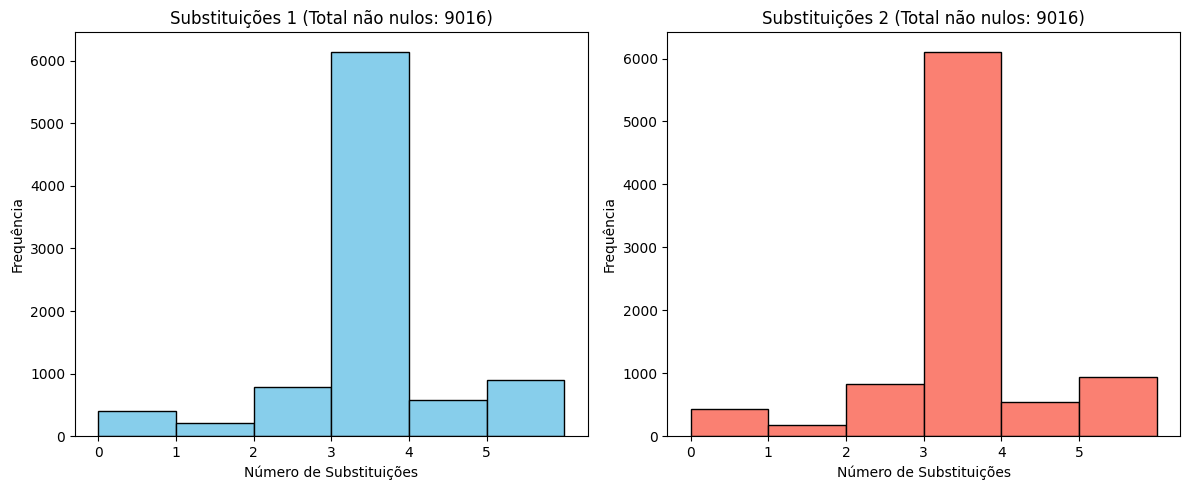

In [2]:
plotar_histogramas_duplos('saida_sem_outliers.csv', 'Substituições 1', 'Substituições 2')

Com os dados que temos, percebemos que geralmente acontecem 3 substituições por jogo.

## Vamos dar uma olhada nas correlações!

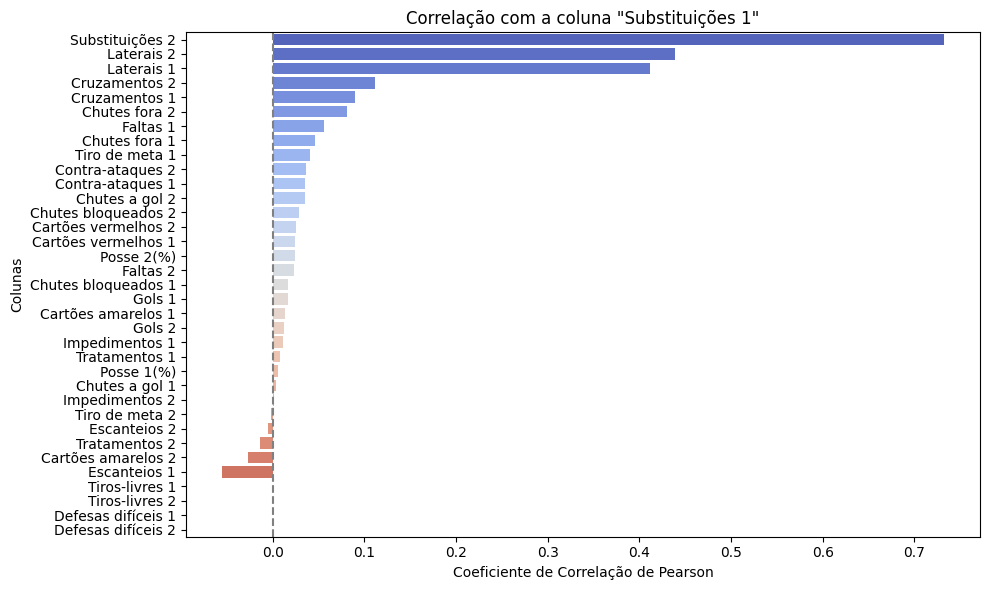

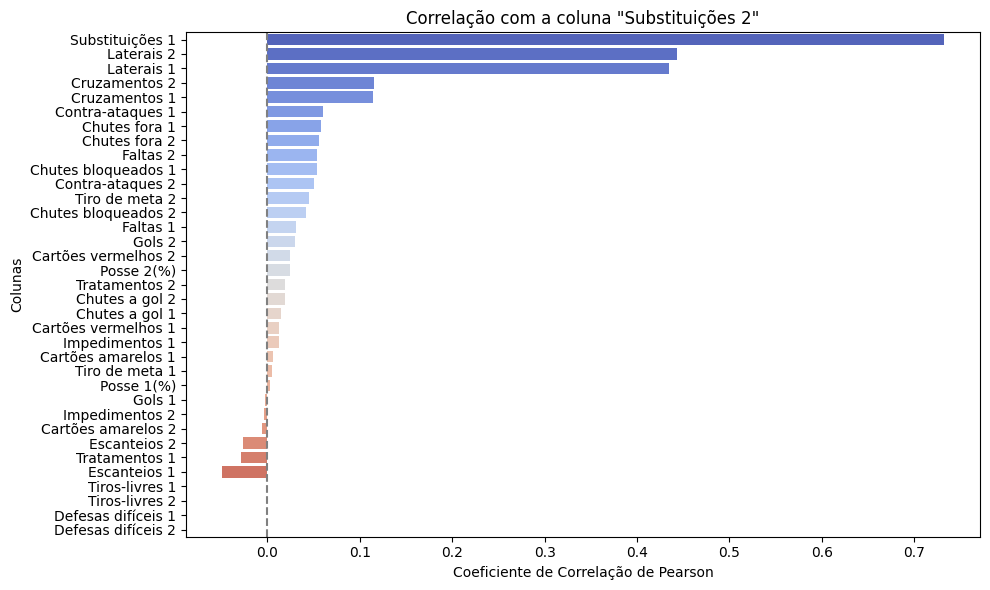

In [3]:
grafico_correlacoes('saida_sem_outliers.csv', 'Substituições 1')
grafico_correlacoes('saida_sem_outliers.csv', 'Substituições 2')

As maiores correlações são a Substituição do time oponente e dos números de Laterais 2 e 1

## Vamos tentar substituir usando uma mistura de Correlação e Mediana

### Como funciona?

---
Se Correlação entre coluna 1 e coluna 2 >= 0.7
    Se ((coluna 1 == null)  e  (coluna 2 != null))   ou   ((coluna 2 == null)  e  (coluna 1 != null)):
        usar a coluna não nula para preencher a coluna nula
Se Correlação entre coluna 1 e coluna 2 < 0.7
    usar a mediana para preencher a coluna nula

In [4]:
preencher_nulos_com_base_em_correlacao('saida_sem_outliers.csv', 'saida_com_valores_substituidos.csv', 'Substituições 1', 'Substituições 2', limite_correlacao=0.7)

[INFO] Correlação entre 'Substituições 1' e 'Substituições 2': 0.73

[RESULTADO - Substituições 1]
Preenchidos por correlação: 0
Preenchidos por mediana:    17786

[RESULTADO - Substituições 2]
Preenchidos por correlação: 0
Preenchidos por mediana:    17786


Podemos ver que apenas foi feito preenchimento usando mediana, isso acontece por que não exisitiu nenhum caso que um deles fosse nulo e outro fosse valor válido. Tornando difícil assim, a cópia de dados da outra coluna, pois é sempre ter as duas informações ou não ter nenhuma. Por isso a solução que nos resta é a da mediana.

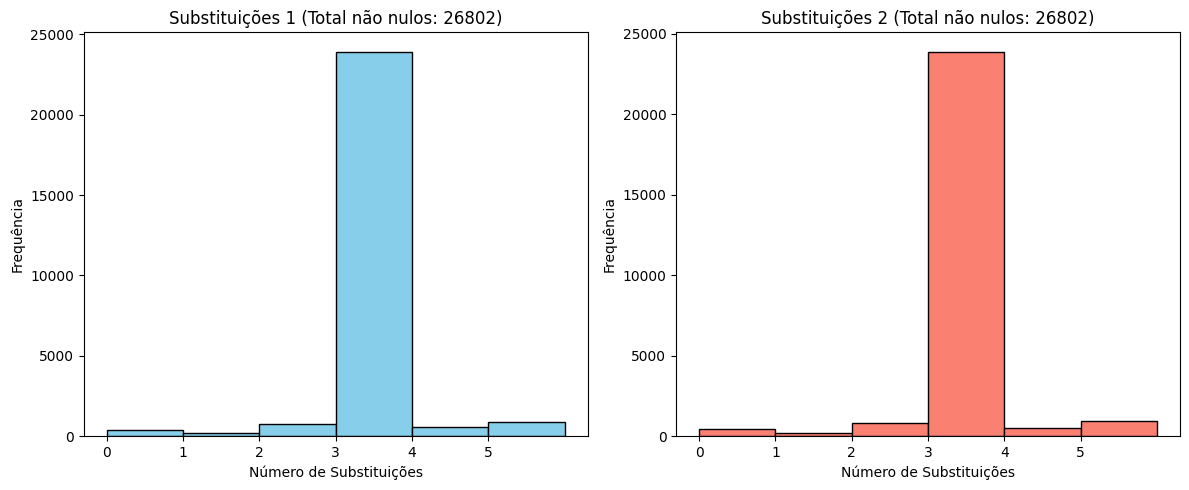

In [5]:
plotar_histogramas_duplos('saida_com_valores_substituidos.csv', 'Substituições 1', 'Substituições 2')

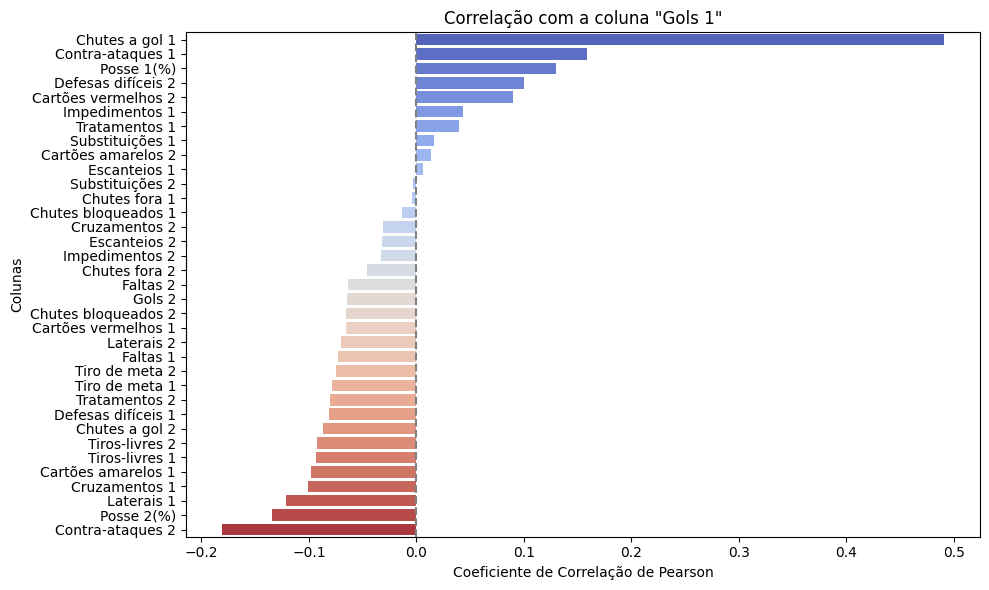

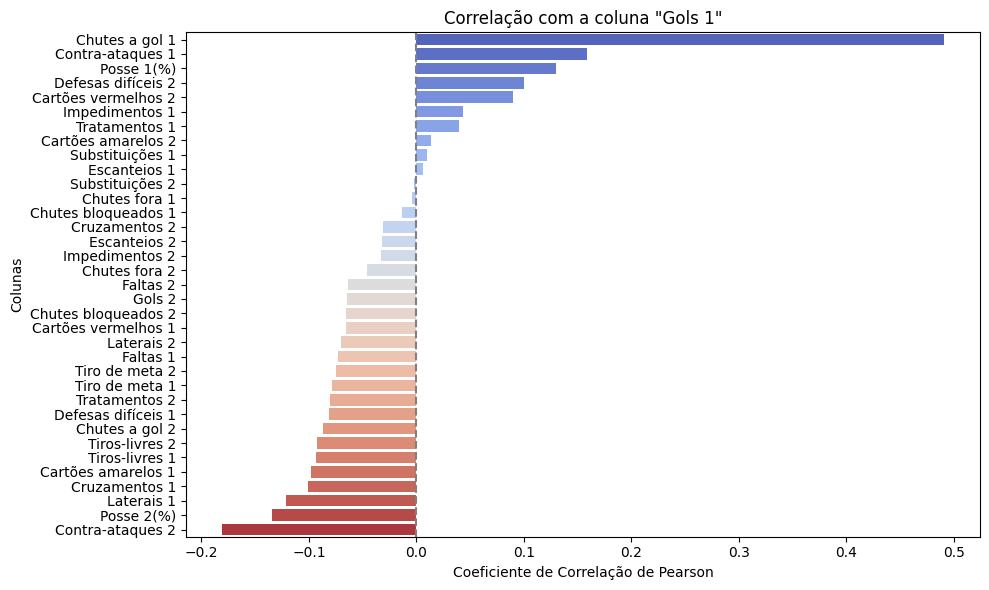

In [6]:
grafico_correlacoes('saida_sem_outliers.csv', 'Gols 1')
grafico_correlacoes('saida_com_valores_substituidos.csv', 'Gols 1')

# Conclusão

Podemos ver que a correlação de Gols não foi alterada praticamente. E além disso, vimos que o impacto dessa coluna com Gols já era baixo e se manteve assim. Nos levando a crer que Substituições são irrelevantes para um modelo de previsão de resultados de gols.